In [ ]:
# Install required packages
!pip install -q transformers torch tensorflow pandas numpy matplotlib seaborn scikit-learn optuna

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertModel
from tensorflow.keras.callbacks import EarlyStopping
import optuna
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Section 1: EDA (Exploratory Data Analysis)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

def perform_eda(train_df):
    # Basic information about the dataset
    print("\nTraining Dataset Info:")
    print(train_df.info())

    print("\nMissing values:")
    print(train_df.isnull().sum())

    # Distribution of duplicate vs non-duplicate questions
    plt.figure(figsize=(8, 6))
    sns.countplot(x='is_duplicate', data=train_df)
    plt.title('Distribution of Duplicate vs Non-Duplicate Questions')
    plt.show()

    # Question length analysis
    train_df['q1_len'] = train_df['question1'].str.len()
    train_df['q2_len'] = train_df['question2'].str.len()

    # Length distributions
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(train_df['q1_len'], bins=50, color='blue', alpha=0.5)
    plt.title('Question 1 Length Distribution')

    plt.subplot(1, 2, 2)
    sns.histplot(train_df['q2_len'], bins=50, color='blue', alpha=0.5)
    plt.title('Question 2 Length Distribution')
    plt.tight_layout()
    plt.show()

    # Word clouds
    def create_wordcloud(text_series, title):
        text = ' '.join(text_series.dropna().astype(str))
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title)
        plt.show()

    create_wordcloud(train_df['question1'], 'Word Cloud - Question 1')
    create_wordcloud(train_df['question2'], 'Word Cloud - Question 2')

    # Basic statistics
    print("\nBasic statistics of question lengths:")
    print(train_df[['q1_len', 'q2_len']].describe())

    return train_df


In [ ]:
# Section 2: Text Preprocessing Pipeline
class QuestionSimilarityDataset(Dataset):
    def __init__(self, questions1, questions2, labels, tokenizer, max_length=128):
        self.tokenizer = tokenizer
        self.questions1 = questions1
        self.questions2 = questions2
        self.labels = labels
        self.max_length = max_length

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        q1 = str(self.questions1[idx])
        q2 = str(self.questions2[idx])

        encoding = self.tokenizer.encode_plus(
            q1, q2,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }

def preprocess_data(train_df, batch_size=16):
    # Split data into train and validation sets
    train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['is_duplicate'])

    # Initialize tokenizer with longer sequence length
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

    # Create datasets with augmentation
    def create_augmented_dataset(df):
        # Simple augmentation: swap question1 and question2 for duplicate pairs
        aug_df = df[df['is_duplicate'] == 1].copy()
        aug_df['temp'] = aug_df['question1']
        aug_df['question1'] = aug_df['question2']
        aug_df['question2'] = aug_df['temp']
        aug_df = aug_df.drop('temp', axis=1)
        return pd.concat([df, aug_df], ignore_index=True)

    augmented_train_df = create_augmented_dataset(train_df)

    train_dataset = QuestionSimilarityDataset(
        augmented_train_df['question1'].values,
        augmented_train_df['question2'].values,
        augmented_train_df['is_duplicate'].values,
        tokenizer
    )

    val_dataset = QuestionSimilarityDataset(
        val_df['question1'].values,
        val_df['question2'].values,
        val_df['is_duplicate'].values,
        tokenizer
    )

    # Create dataloaders with proper worker settings
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        num_workers=2,
        pin_memory=True
    )

    return train_loader, val_loader, val_df['is_duplicate'].values

In [ ]:
# Section 3: Model Building and Training
class DistilBERTSimilarity(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super().__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')

        # Enhanced architecture
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear(768, 512)
        self.batch_norm1 = nn.BatchNorm1d(512)

        self.dropout2 = nn.Dropout(dropout_rate/2)
        self.dense2 = nn.Linear(512, 256)
        self.batch_norm2 = nn.BatchNorm1d(256)

        self.classifier = nn.Linear(256, 1)

        # Selective fine-tuning
        for param in self.distilbert.parameters():
            param.requires_grad = False
        # Fine-tune the last 3 layers instead of 2
        for i in range(3):
            for param in self.distilbert.transformer.layer[-(i+1)].parameters():
                param.requires_grad = True

    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Enhanced forward pass with residual connections
        pooled_output = outputs.last_hidden_state[:, 0]

        x = self.dropout1(pooled_output)
        x = self.dense1(x)
        x = self.batch_norm1(x)
        x = F.gelu(x)  # Using GELU activation

        x = self.dropout2(x)
        x = self.dense2(x)
        x = self.batch_norm2(x)
        x = F.gelu(x)

        return torch.sigmoid(self.classifier(x))

def train_model(model, train_loader, val_loader, device, num_epochs=10):
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=2e-5,
        weight_decay=0.01,
        betas=(0.9, 0.999)
    )

    # Learning rate scheduler
    scheduler = CosineAnnealingWarmRestarts(
        optimizer,
        T_0=2,  # Reset after every 2 epochs
        T_mult=2  # Double the reset interval after each reset
    )

    # Focal Loss for better handling of class imbalance
    class FocalLoss(nn.Module):
        def __init__(self, alpha=1, gamma=2):
            super().__init__()
            self.alpha = alpha
            self.gamma = gamma

        def forward(self, inputs, targets):
            bce_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
            pt = torch.exp(-bce_loss)
            focal_loss = self.alpha * (1-pt)**self.gamma * bce_loss
            return focal_loss.mean()

    criterion = FocalLoss()
    best_val_loss = float('inf')
    patience = 3
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training phase with gradient accumulation
        model.train()
        total_train_loss = 0
        optimizer.zero_grad()

        for i, batch in enumerate(train_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs.squeeze(), labels)

            # Gradient accumulation every 4 steps
            loss = loss / 4
            loss.backward()

            if (i + 1) % 4 == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()

            total_train_loss += loss.item() * 4

        # Validation phase
        model.eval()
        total_val_loss = 0
        val_predictions = []
        val_labels = []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs.squeeze(), labels)
                total_val_loss += loss.item()

                val_predictions.extend(outputs.squeeze().cpu().numpy() > 0.5)
                val_labels.extend(labels.cpu().numpy())

        # Learning rate scheduling
        scheduler.step()

        # Early stopping check
        avg_val_loss = total_val_loss / len(val_loader)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pt')
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered after epoch {epoch+1}")
            break

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Average train loss: {total_train_loss/len(train_loader):.4f}')
        print(f'Average validation loss: {avg_val_loss:.4f}')

    return model

In [ ]:
# Section 4: Evaluation of Model Performance
def evaluate_bert_model(model, val_loader, y_val):
    """
    Evaluate the BERT model performance
    Args:
        model: The trained PyTorch model
        val_loader: Validation data loader
        y_val: True labels
    """
    model.eval()
    all_predictions = []
    all_probs = []

    # Get predictions
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(model.device)
            attention_mask = batch['attention_mask'].to(model.device)

            outputs = model(input_ids, attention_mask)
            probs = outputs.squeeze().cpu().numpy()
            preds = (probs > 0.5).astype(int)

            all_predictions.extend(preds)
            all_probs.extend(probs)

    # Convert lists to numpy arrays
    predictions = np.array(all_predictions)
    y_pred = np.array(all_probs)

    # Calculate metrics
    accuracy = accuracy_score(y_val, predictions)
    precision = precision_score(y_val, predictions)
    recall = recall_score(y_val, predictions)
    f1 = f1_score(y_val, predictions)

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(y_val, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Print metrics
    print("\nModel Performance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'predictions': predictions,
        'probabilities': y_pred
    }



Loading data...

Training Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            100000 non-null  int64 
 1   qid1          100000 non-null  int64 
 2   qid2          100000 non-null  int64 
 3   question1     100000 non-null  object
 4   question2     100000 non-null  object
 5   is_duplicate  100000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 4.6+ MB
None

Missing values:
id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64


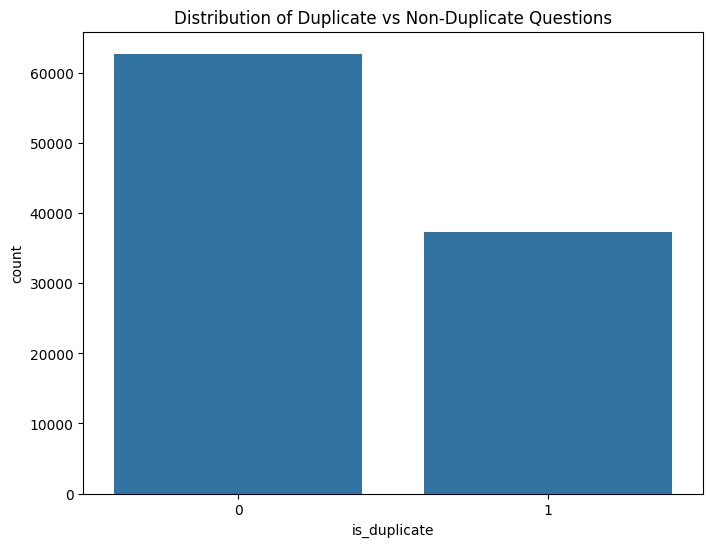

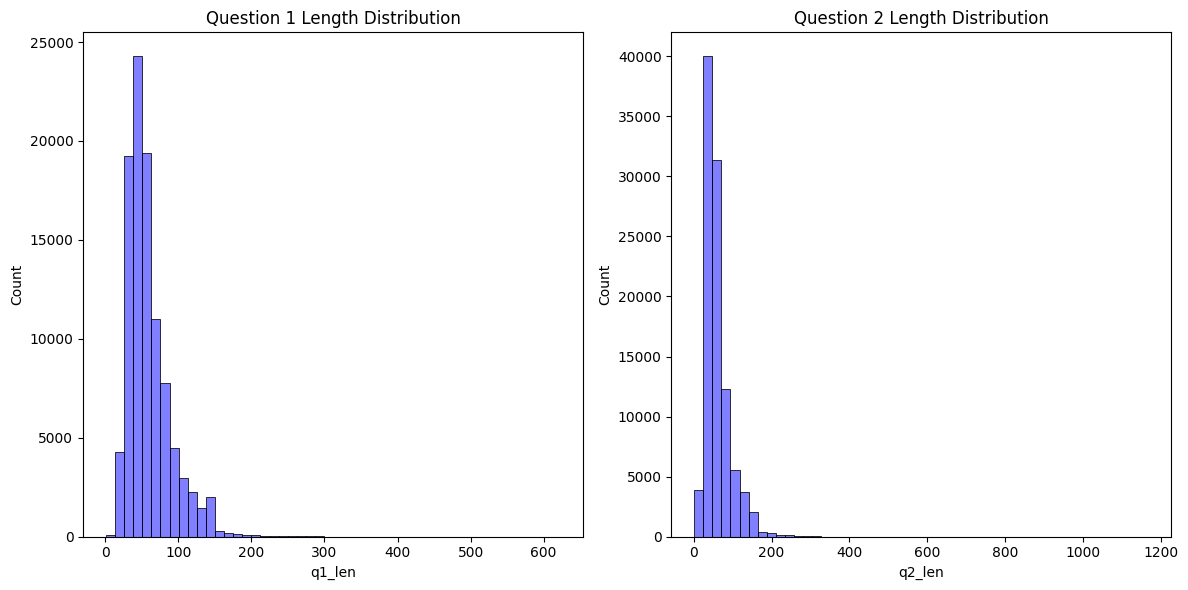

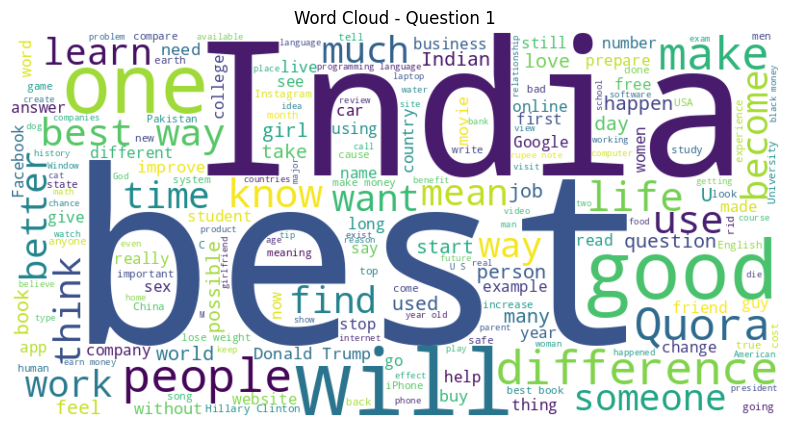

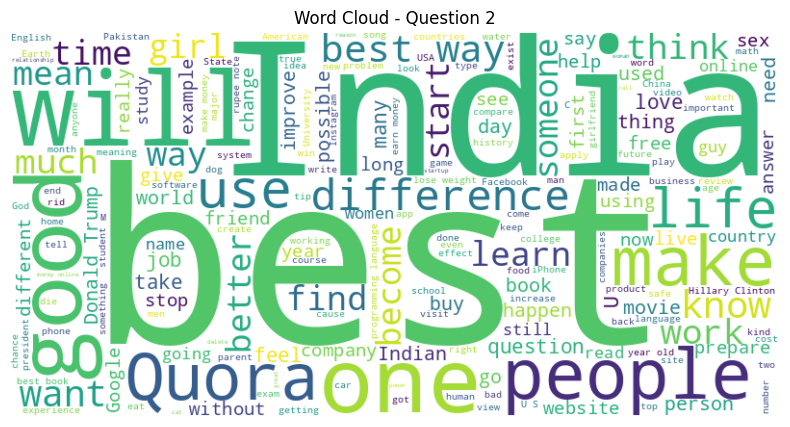


Basic statistics of question lengths:
              q1_len         q2_len
count  100000.000000  100000.000000
mean       59.386340      60.024250
std        29.948633      34.052809
min         1.000000       1.000000
25%        39.000000      39.000000
50%        52.000000      51.000000
75%        71.000000      71.000000
max       623.000000    1169.000000


In [ ]:
# Main execution
if __name__ == "__main__":
    # Load data
    file_path = "/content/drive/MyDrive/train.csv"
    print("Loading data...")
    SAMPLE_SIZE = 100000  # Adjust based on computational resources
    train_df = pd.read_csv(file_path, nrows=SAMPLE_SIZE)

    # Perform EDA
    train_df = perform_eda(train_df)


In [ ]:
    # Preprocess data with optimized batch size
    train_loader, val_loader, y_val = preprocess_data(train_df, batch_size=16)

    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DistilBERTSimilarity().to(device)
    model.device = device  # Store device information in model

    # Train model
    model = train_model(model, train_loader, val_loader, device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch 1/10:
Average train loss: 0.1199
Average validation loss: 0.0961


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch 2/10:
Average train loss: 0.0951
Average validation loss: 0.0898


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch 3/10:
Average train loss: 0.0876
Average validation loss: 0.0886


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch 4/10:
Average train loss: 0.0746
Average validation loss: 0.0928


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch 5/10:
Average train loss: 0.0632
Average validation loss: 0.0958


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Early stopping triggered after epoch 6


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


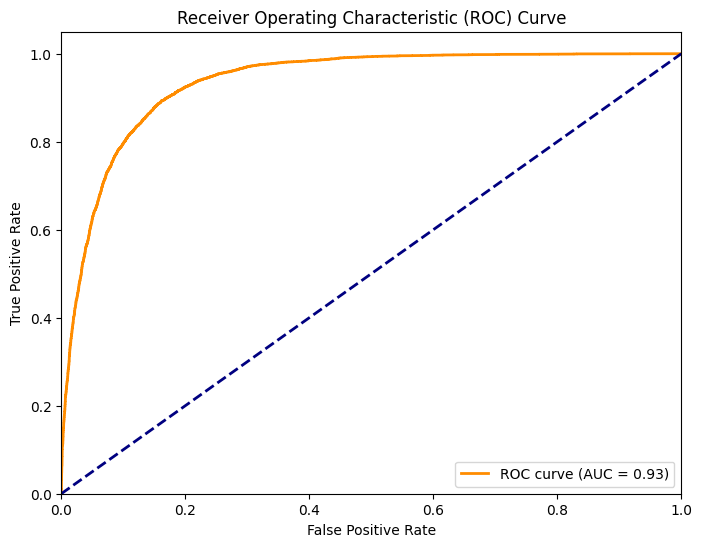

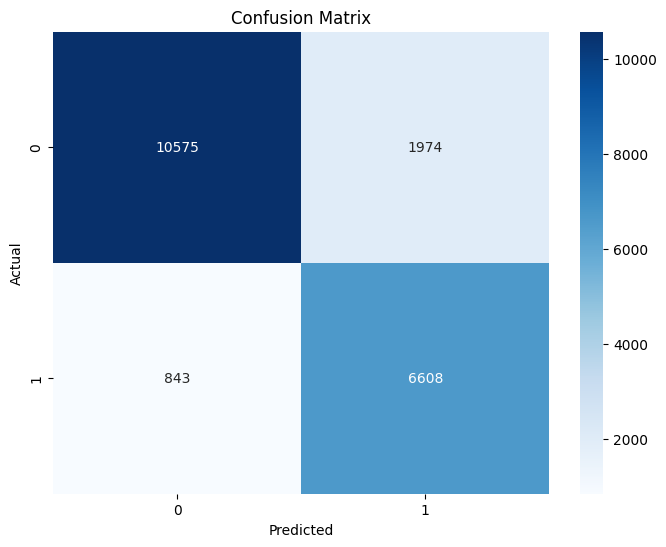


Model Performance Metrics:
Accuracy: 0.8591
Precision: 0.7700
Recall: 0.8869
F1-Score: 0.8243
ROC AUC: 0.9348


In [ ]:

    # Evaluate model
    metrics = evaluate_bert_model(model, val_loader, y_val)